In [1]:
import cv2
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pytesseract
import pyzbar.pyzbar as pyzbar
from gtts import gTTS
from playsound import playsound
import os

print(cv2.__version__)

4.5.1


['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
['', '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']
[8801062521487, '']

KeyboardInterrupt: 

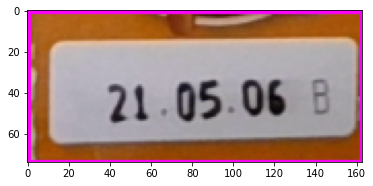

In [4]:
cap = cv2.VideoCapture(0)

i = 0
whT = 320

confThreshold = 0.5
nmsThreshold = 0.3

EDrac = [0,0,0,0,0]
x,y,w,h = 0,0,0,0
#EDBC= np.array()

classesFile = 'obj.names'   #내가 가지는 클래스 이름이 들어가있는 파일
classNames = []

with open(classesFile, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')   #Expiration date 하나밖에 없어서 이거 하나
    
    
#print(classNames)
#print(len(classNames))

modelConfiguration= 'yolov3_ED.cfg' #모델 구조
modelWeights= 'yolov3_best.weights' #가중치

net = cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights) #다크넷 실행 모델구조랑 가중치 들고오겠다.
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) #
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def findObjects(outputs,img):
    hT, wT, cT, = img.shape
    bbox= []
    classIds = []
    confs = []
    
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId= np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                w,h = int(det[2]*wT), int(det[3]*hT)
                x,y = int((det[0]*wT)-w/2), int((det[1]*hT)-h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices = cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    #네모치는 곳
    for i in indices:
        i = i[0]
        box = bbox[i]
        x,y,w,h = box[0],box[1],box[2],box[3]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.putText(img,f'{classNames[classIds[i]].upper()} {int(confs[i]*100)}%', (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
            
        #print(classNames[classIds[i]].upper())
        if indices == [[0]]:
            EDrac[0] = 1
            EDrac[1] = x
            EDrac[2] = y
            EDrac[3] = w
            EDrac[4] = h
        else:
            EDrac[0]= 0
        
        if EDrac[0] == 1:
            ED_pic = img[EDrac[2]:EDrac[2]+EDrac[4], EDrac[1]:EDrac[1]+EDrac[3]]
            plt.imshow(ED_pic)
            
            #1
            img_ori = ED_pic

            height, width, channel = img_ori.shape

            gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)

            structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

            imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
            imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

            imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
            gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

            img_blurred = cv2.GaussianBlur(gray, ksize=(9, 9), sigmaX=0)

            img_thresh = cv2.adaptiveThreshold(
                img_blurred, 
                maxValue=255.0, 
                adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                thresholdType=cv2.THRESH_BINARY_INV, 
                blockSize=19, 
                C=6
            )


            #print(pytesseract.image_to_boxes(img_thresh))

            #cv2.imshow('Result',img_ori)
            #cv2.waitKey(0)
            hImg,wImg,_ = img_ori.shape

            boxes = pytesseract.image_to_boxes(img_thresh)
            ED = ''
            for b in boxes.splitlines():
                #print(b)
                b= b.split(' ')
                #x,y,w,h = int(b[1]),int(b[2]),int(b[3]),int(b[4])
                #cv2.rectangle(img_ori,(x,hImg-y),(w,hImg-h),(0,0,255),1)
                #cv2.putText(img_ori,b[0],(x,hImg-y+25),cv2.FONT_HERSHEY_COMPLEX,1,(50,50,255),1)
                ED += b[0]
                
            if len(ED) >= 8:
                if ED[0]== '2':
                    ED_ARRAY[1] = ED[:8]
                    EDT= '유통기한은'+ED_ARRAY[1]+'까지 입니다.'
                    EDtts = gTTS(text=EDT, lang='ko')
                    EDtts.save("EDtts.mp3")
                    playsound("EDtts.mp3",False)
                    os.remove("EDtts.mp3")


def bacode(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     
    decoded = pyzbar.decode(gray)

    for d in decoded: 
        x, y, w, h = d.rect

        barcode_data = d.data.decode("utf-8")
        barcode_type = d.type

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

        text = '%s' % (barcode_data)
        cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        ED_ARRAY[0] = int(barcode_data)
        PROT = '이 제품은'+'상큼달콤 롯데샌드'+'입니다.'
        PROtts = gTTS(text=PROT, lang='ko')
        PROtts.save("PROtts.mp3")
        playsound("PROtts.mp3",False)
        os.remove("PROtts.mp3")

ED_ARRAY = ['','']
        
while(cap.isOpened()):
    ret, img = cap.read()

    
    if not ret:
        continue
        
    blob = cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
    net.setInput(blob)

    layerNames = net.getLayerNames()
   # print(layerNames)
    outputNames = [layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]
    #print(outputNames) 
   # print(net.getUnconnectedOutLayers())

    outputs = net.forward(outputNames)
    
    key = cv2.waitKey(1)

    if ED_ARRAY[0]=='':
        bacode(img)
    
    if ED_ARRAY[0]!='' and ED_ARRAY[1]=='':
        findObjects(outputs,img)

    
    cv2.imshow('img', img)
    print(ED_ARRAY)
    if key == ord('q'):
        break
    elif key == ord('s'):
        i += 1
    cv2.imwrite('c_%03d.jpg' % i, img)

cap.release()
cv2.destroyAllWindows()
